In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nips-papers/paper_authors.csv
/kaggle/input/nips-papers/papers.csv
/kaggle/input/nips-papers/authors.csv
/kaggle/input/nips-papers/database.sqlite


# About NeurIPS and the dataset 
**Neural Information Processing Systems** abbreviated as NeurIPS is one of the top machine learning conferences in the world. It covers topics ranging from deep learning and computer vision to cognitive science and reinforcement learning.

The dataset used in this notebook includes all the paper published between 1987 and 2017 in NeurIPS. There are three csv file **"authors.csv"**, **"papers.csv"** and **"paper_authors.csv"**. Both **"authors.csv"** and **"papers.csv"** file contains "author_id" and "paper_id" which are matched with a unique id in **"paper_authors.csv"**   

In this notebook I am going to run different analysis. Through the analysis I will try to extract different information which can be very interesting.  

#### At first we would import all the necessary libraries 

In [2]:
#general computation libraries
import numpy as np
import pandas as pd 

#visualization libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

#### Now let's load the dataset

In [3]:
authors=pd.read_csv("/kaggle/input/nips-papers/authors.csv")
papers=pd.read_csv("/kaggle/input/nips-papers/papers.csv")
papers_authors=pd.read_csv("/kaggle/input/nips-papers/paper_authors.csv")

after loading the dataset now we will **surf the datasets** to **understand** it's characteristics and other **properties**.

In [4]:
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9784 entries, 0 to 9783
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9784 non-null   int64 
 1   name    9784 non-null   object
dtypes: int64(1), object(1)
memory usage: 153.0+ KB


In [5]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7241 non-null   int64 
 1   year        7241 non-null   int64 
 2   title       7241 non-null   object
 3   event_type  2422 non-null   object
 4   pdf_name    7241 non-null   object
 5   abstract    7241 non-null   object
 6   paper_text  7241 non-null   object
dtypes: int64(2), object(5)
memory usage: 396.1+ KB


Our main target is to analyze the text. Before that let's have some basic EDA.

Let's see how many papers published since 1987 till 2017

Text(0, 0.5, 'Total Papers')

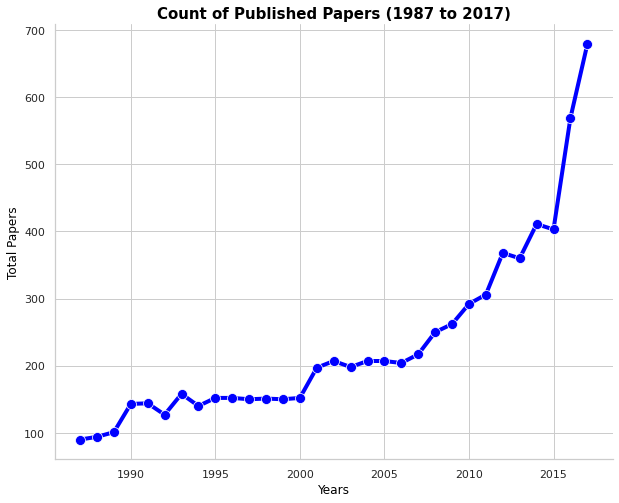

In [6]:
sns.set_theme(style='whitegrid')
fig,ax=plt.subplots(figsize=(10,8))

ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True);ax.spines['left'].set_visible(True)

sns.lineplot(data=papers['year'].value_counts(),marker='o',markersize=10,color='blue',linewidth=4)
ax.set_title("Count of Published Papers (1987 to 2017)",loc='center',color='black',fontsize=15,fontweight='semibold')
ax.set_xlabel("Years",loc='center',color='black',fontsize=12,fontweight='normal')
ax.set_ylabel("Total Papers",loc='center',color='black',fontsize=12,fontweight='normal')

from the line chart it is evident that total number of papers published in NeurIPS increasing drastically with the year. 